In [255]:
from opentrons import simulate, execute
from opentrons.types import Location, Point

import numpy as np
import pandas as pd
import time
import math
import matplotlib.pyplot as plt

api_level= '2.11'

If we want to simulate:

In [259]:
protocol = simulate.get_protocol_api(api_level)

protocol.home()

C:\Users\raras\.opentrons\robot_settings.json not found. Loading defaults
C:\Users\raras\.opentrons\deck_calibration.json not found. Loading defaults


In [260]:
tips_300 = protocol.load_labware("opentrons_96_tiprack_300ul", 1)

reservoir = protocol.load_labware("nest_12_reservoir_15ml", 2)

tips_20 = protocol.load_labware("opentrons_96_filtertiprack_20ul", 4)

plate = protocol.load_labware("corning_384_wellplate_112ul_flat", 5)

tube_rack1 = protocol.load_labware("opentrons_10_tuberack_falcon_4x50ml_6x15ml_conical", 6)

tube_rack2 = protocol.load_labware("opentrons_10_tuberack_falcon_4x50ml_6x15ml_conical", 7)

# pcr_tubes_plate = protocol.load_labware("opentrons_96_aluminumblock_generic_pcr_strip_200ul", 2)

In [261]:
protein_cs = [1,3,6,12]
salt_cs = [50, 100, 150, 200]
pHs = [6.5, 7.5, 8.5]
# DNA = [False, True]

In [435]:
salt_buffer = {
    "name": "Salty buffer",
    "pos": tube_rack["A1"],
    "vols": [5, 10, 15, 20],
}
normal_buffer = {
    "name": "Normal buffer",
    "pos": tube_rack["A2"],
    "vols": [20, 15, 10, 5]
}

DNA = {
    "pos": tube_rack["A3"],
    "vol": 1,
}

acids = {
    "high": {"pos": tube_rack2["A1"],
            "vol": 0},
    "middle": {"pos": tube_rack2["A2"],
              "vol": 0},
    "low": {"pos": tube_rack2["A3"],
           "vol": 0},
}

protein = {
    "high": {"pos": tube_rack1["A1"],
            "vol": 0},
    "middle": {"pos": tube_rack1["A2"],
              "vol": 0},
    "low": {"pos": tube_rack1["A3"],
           "vol": 0},
    "buffer": {
        "pos": normal_buffer["pos"]
    }
}
water = {
    "pos": tube_rack["B3"]
}

In [433]:
block_shape = (len(pHs), len(DNA))
overall_shape = (4,4,2,3)
wells_to_fill = np.array(plate.wells()).reshape(24,16)[0:8,0:12]

In [430]:
wells_blockshaped = blockshaped(wells_to_fill, 2, 3)

In [199]:
pip = protocol.load_instrument("p300_single_gen2", "left", tip_racks=[tips_300])

RuntimeError: Instrument already present in left mount: p300_single_gen2

In [214]:
blockshaped(wells_to_be_filled, 2,3)

array([[[A1 of Corning 384 Well Plate 112 µL Flat on 5,
         B1 of Corning 384 Well Plate 112 µL Flat on 5,
         C1 of Corning 384 Well Plate 112 µL Flat on 5],
        [A2 of Corning 384 Well Plate 112 µL Flat on 5,
         B2 of Corning 384 Well Plate 112 µL Flat on 5,
         C2 of Corning 384 Well Plate 112 µL Flat on 5]],

       [[D1 of Corning 384 Well Plate 112 µL Flat on 5,
         E1 of Corning 384 Well Plate 112 µL Flat on 5,
         F1 of Corning 384 Well Plate 112 µL Flat on 5],
        [D2 of Corning 384 Well Plate 112 µL Flat on 5,
         E2 of Corning 384 Well Plate 112 µL Flat on 5,
         F2 of Corning 384 Well Plate 112 µL Flat on 5]],

       [[G1 of Corning 384 Well Plate 112 µL Flat on 5,
         H1 of Corning 384 Well Plate 112 µL Flat on 5,
         I1 of Corning 384 Well Plate 112 µL Flat on 5],
        [G2 of Corning 384 Well Plate 112 µL Flat on 5,
         H2 of Corning 384 Well Plate 112 µL Flat on 5,
         I2 of Corning 384 Well Plate 1

## For visualization:

In [9]:
wells_reshaped = np.array(plate.wells()).reshape((24,16))
zeros = np.zeros(wells_reshaped.shape)
zeros = np.swapaxes(zeros, 0, 1)

# Buffers:

In [157]:
if not pip.hw_pipette["has_tip"]:
    pip.pick_up_tip()

for buffer in (salt_buffer, normal_buffer):
    print(f'Pipetting buffer: {buffer["name"]}')
    vols = buffer["vols"]
    for i_s, c_s in enumerate(salt_cs):
        from_row = i_s * block_shape[0]
        to_row = from_row + block_shape[0]
        to_column = len(protein_cs) * block_shape[1]

        block = wells_reshaped[0:to_column,from_row:to_row]

        current_vis_block = np.copy(zeros)
        current_vis_block[from_row:to_row,0:to_column] = 1
        print(f'Pipetting {vols[i_s]} µl into this block:')
        print(current_vis_block)

        for well in block.flatten():
            pip.aspirate(vols[i_s],
                        buffer["pos"])
            pip.dispense(vols[i_s],
                        well)

Pipetting buffer: Salty buffer
Pipetting 5 µl into this block:
[[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

# pH

$
    pH = pK_{a} - log(\frac{[HA]}{[A^-]})
$

$
    pK_{a, TRIS, 25°C} = 8.1
$

For a 50 mM Tris-Buffer at pH 8.5, we have 50 mM Tris and 14.71 mM HCl.
I.e. 35.29 mM Tris base and 14.71 conjugated acid.

### Calculations:

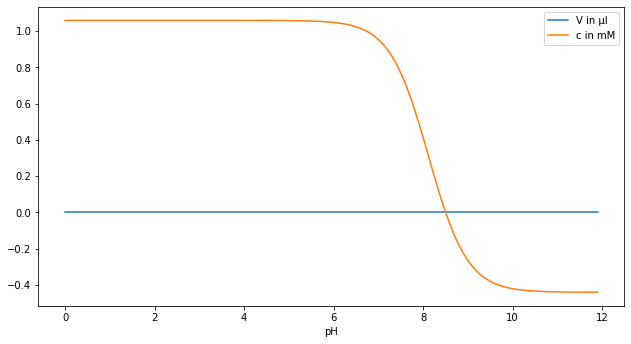

In [399]:
pHs = np.arange(0,12, 0.1)
pKa = 8.12
base = 35.29 *10**-3 # M
acid = 14.71 *10**-3 # M
c0_HCl = 12.1 # M = 37.2%
# V_well = 0.000003 # l
V_well = 3 * 10**-5
V_to_pipette = 1 * 10**-6 # µl

# This functions takes in a desired pH and return the amount of HCl needed to achieve that pH
def get_V(pH):
    ratio = 10**(pKa-pH)
    c1_HCl = (ratio * base - acid)/(1+ratio)
    V = (c1_HCl * V_well)/c0_HCl
    V = V  # return in µl
    return V

# This functions takes in a desired V and returns the concentration of HCl needed to achieve that pH
def get_c(pH):
    ratio = 10**(pKa-pH)
    c1_HCl = (ratio * base - acid)/(1+ratio)
    c = (c1_HCl * V_well)/V_to_pipette
    c = c  # return in µM
    return c

fig, ax = plt.subplots(figsize = (10.5,5.5))
V_acid = [get_V(pH) for pH in pHs]
ax.plot(pHs, V_acid, label="V in µl");

c_acid = [get_c(pH) for pH in pHs]
ax.plot(pHs, c_acid, label="c in mM");
ax.set_xlabel("pH")
ax.legend();

For the adjustment of pH, the plan is to always add 1 µl (minimum working volume of the pipette p20) of acid. 
In order to have different pHs, we prepare 2 differently concentrated HCl stock solutions.

In [400]:
V_min_HCl = len(wells_to_fill.flatten()) * 1
print(V_min_HCl)

96


In [401]:
print(f'The first solution needs a concentration of {get_c(6.5):.2f} M')
print(f'The second solution needs a concentration of {get_c(7.5):.2f} M')

The first solution needs a concentration of 1.02 M
The second solution needs a concentration of 0.77 M


In [402]:
V_HCl_stock = 1*10**-3 # l
acids["middle"]["vol"] = get_c(7.5) * V_HCl_stock / (c0_HCl ) * 10**6 
acids["low"]["vol"] = get_c(6.5) * V_HCl_stock / (c0_HCl ) * 10**6 

print(f'We need {acids["middle"]["vol"]} µl and {acids["low"]["vol"]} µl HCl ')

We need 63.51167638228608 µl and 84.59177234856418 µl HCl 


### Prepare different HCl solutions

In [404]:
if not pip.hw_pipette["has_tip"]:
    pip.pick_up_tip()

acid_stock = acids["high"]

for acid in [acids["middle"], acids["low"]]:
    pip.aspirate(V_HCl_stock - acid["vol"],
                water["pos"])
    pip.dispense(V_HCl_stock - acid["vol"],
                acid["pos"])

for acid in [acids["middle"], acids["low"]]:
    pip.aspirate(acid["vol"],
                acid_stock["pos"])
    pip.dispense(acid["vol"],
                acid["pos"])

### Pipette 1 µl of HCl in each well:

In [411]:
if not pip.hw_pipette["has_tip"]:
    pip.pick_up_tip()

vol = 1

for i_a, name in enumerate(acids):
    acid = acids[name]
    wells = np.swapaxes(wells_reshaped[0:8,i_a:12:3], 0,1)
    
    current_vis_block = np.copy(zeros)
    current_vis_block[i_a:12:3,0:8] = 1
    print(f'Pipetting {vol} µl acid into these rows:')
    print(current_vis_block)
    
    for well in wells.flatten():
#         print(f'Pipetting {vol} µl into {well}')
        pip.aspirate(vol,
                    acid["pos"])
        pip.dispense(vol,
                    well)

Pipetting 1 µl acid into these rows:
[[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

# Add DNA

In [252]:
if not pip.hw_pipette["has_tip"]:
    pip.pick_up_tip()

current_vis_block = np.copy(zeros)
current_vis_block[0:12,0:8:2] = 1
print(f'Pipetting {DNA["vol"]} µl acid into these rows:')
print(current_vis_block)
    
# add DNA in every other row
for well in wells_reshaped[0:8:2,0:12].flatten():
#     print(f'Pipetting {DNA["vol"]} µl into {well}')
    pip.aspirate(DNA["vol"],
                DNA["pos"])
    pip.dispense(DNA["vol"],
                well)

Pipetting 1 µl acid into these rows:
[[1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

# Protein

## Dilution

In [417]:
if not pip.hw_pipette["has_tip"]:
    pip.pick_up_tip()
    
p_stock = protein["high"]    
vols = [10,20]
for i_p,p in enumerate([protein["middle"], protein["low"]]):
    pip.aspirate(vols[i_p], p_stock["pos"])
    pip.dispense(vols[i_p], p["pos"])

## Final transfer:

In [436]:
if not pip.hw_pipette["has_tip"]:
    pip.pick_up_tip()

vol = 5
for i_p, name in enumerate(protein):
    p = protein[name]
    print(i_p)
    from_column = i_p * overall_shape[2]
    to_column = from_column + overall_shape[2]
    to_row = len(salt_buffer["vols"]) * overall_shape[3]

    print(from_column, to_column, to_row)
    block = wells_reshaped[from_column:to_column,0:to_row]

    current_vis_block = np.copy(zeros)
    current_vis_block[0:to_row, from_column:to_column] = 1
    print(f'Pipetting {vol} µl into this block:')
    print(current_vis_block)

    for well in block.flatten():
        pip.aspirate(vol,
                    p["pos"])
        pip.dispense(vol,
                    well)

0
0 2 12
Pipetting 5 µl into this block:
[[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [427]:
overall_shape

(4, 4, 2, 3)

In [229]:
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
    assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))